# 1 Problem Statement
Alzheimer's disease is a progressive neurological disorder that leads to memory loss, cognitive decline, and ultimately, the inability to perform everyday activities. It is the most common cause of dementia, affecting millions of people worldwide. Despite decades of research, the exact causes of Alzheimer's remain unclear, although it is believed to result from a combination of genetic, environmental, and lifestyle factors. Key pathological features include the accumulation of amyloid plaques and tau tangles in the brain, which disrupt neuronal communication and lead to cell death.

Thus, it is important to develop an artificial intelligence (AI) system capable of detecting Alzheimer's dementia in its early stages. Early detection is critical, as it allows for timely interventions that can significantly improve the quality of life and potentially extend the life expectancy of patients. By identifying the disease before severe cognitive decline sets in, healthcare providers can implement treatment plans and lifestyle changes that slow the progression of dementia, thus preserving the patient's cognitive functions and independence for a longer period.

The [dataset](https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset/data) has four different catergories of Alzheimer's disease:
- Non Demented: patients who do not diagnozied with Alzheimer's disease.

- Very Mild Demented (Preclinical stage):This stage involves subtle memory lapses and slight forgetfulness, which can be mistaken for normal aging. Symptoms are not severe enough to impact daily life significantly, and Alzheimer's may not yet be diagnosable.

- Mild Demented (early stage): Characterized by noticeable memory issues and cognitive challenges, such as difficulty with planning and organizing. Individuals may struggle with remembering recent events and may experience changes in mood or personality, yet can still manage daily tasks with some support.

- Moderate Demented (middle stage): Marked by increased confusion, significant memory loss, and greater difficulty in communication and performing complex tasks. Behavioral changes and a higher need for daily assistance become evident, as independence decreases.

# 2 Methods


In this notebook, I decided to focus on two tasks, Alzhemier Detection and Classification, where detection problem is to determine whether the patient carried the AD or not. 

On the other hand, the classification problem will focus on the differentiating the classes of AD stages.

The detection part used:
- PCA
- SVM

The classification part used:
- Convolutioal Neural Network
- RandomForest

# 3 Testing and Analysis

In [1]:
#Set up the environment and upload the data
from sklearn.preprocessing import StandardScaler
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from skimage.transform import resize
import pandas as pd
from matplotlib.image import imread
from skimage.io import imread_collection
from PIL import Image
import seaborn as sns
from sklearn import decomposition, preprocessing, svm
import sklearn.metrics as metrics #confusion_matrix, accuracy_score
from time import sleep 
from tqdm.notebook import tqdm
import os
sns.set()

In [2]:
very_mild = glob(r'Dataset/Very_Mild_Demented/*')
mild = glob(r'Dataset/Mild_demented/*')
moderate = glob(r'Dataset/Moderate_Demented/*')
non = glob(r'Dataset/Non_Demented/*')

Image shape: (128, 128)
This is a Very_Mild_Demented image


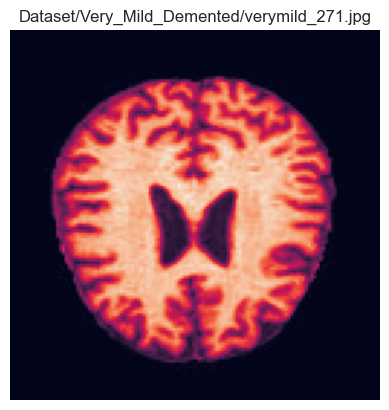

Image shape: (128, 128)
This is a Mild_demented image


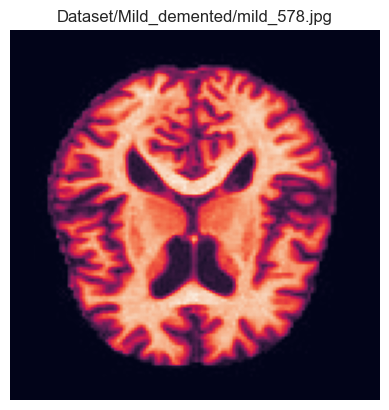

Image shape: (128, 128)
This is a Moderate_Demented image


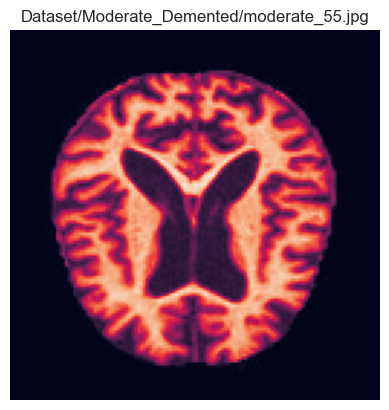

Image shape: (128, 128)
This is a Non_Demented image


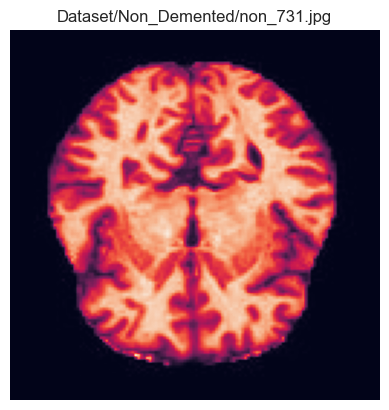

In [3]:
# Load the images
def view_image(directory):
    img = mpimg.imread(directory)
    plt.imshow(img)
    plt.title(directory)
    plt.axis('off')
    print(f'Image shape: {img.shape}')
    return img

for directory in [very_mild, mild, moderate, non]:
    view_image(directory[0])
    print(f'This is a {directory[0].split("/")[-2]} image')
    plt.show()



## 3.1 PCA for Alzheimer Detection

Number of components explaining 80% variance: 1


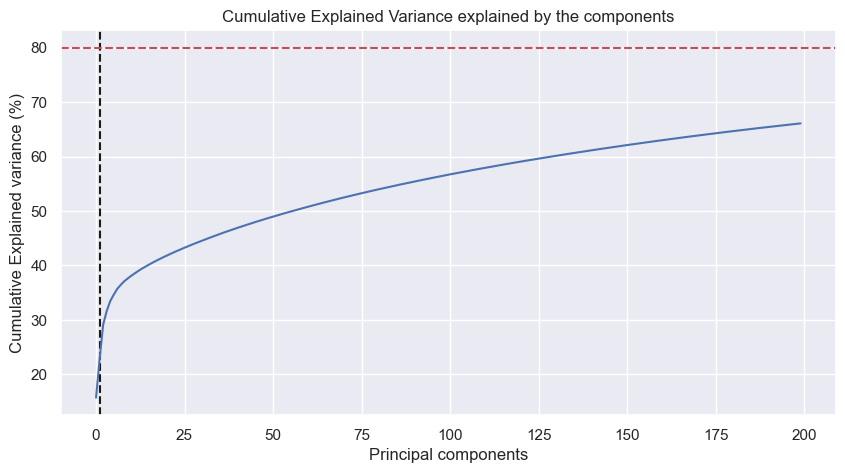

[[ -98.59243378  -62.56915428   49.67589451 ...   -4.28026041
    -2.29216749    2.45071133]
 [ -78.08311965   52.67516166   30.69801762 ...    2.17691834
    -1.02253253    0.76402081]
 [ -76.09536747   11.43161728   28.79069045 ...   -5.15286369
     3.62922562   -0.13683501]
 ...
 [ 103.90972093    9.81869137   10.93451279 ...    2.41448222
    -1.48745002   -2.78070325]
 [-102.91554979   -1.72830298   56.52899261 ...   -6.98002693
     1.29839672   -2.40535859]
 [  36.31790835   59.6574513   -57.49430106 ...    2.074468
     2.48212138   -5.00426249]]


In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Function to flatten images
def extract_feature(directory):
    img = mpimg.imread(directory)  # Read the image from the file path
    img = img / 255.0 # Normalize the pixel values
    img = resize(img,(128,128,3))
    img = np.reshape(img, (128,384))  
    return img

non_ALZ = [extract_feature(filename) for filename in non]
vmild_ALZ = [extract_feature(filename) for filename in very_mild]
mild_ALZ = [extract_feature(filename) for filename in mild]
moderate_ALZ = [extract_feature(filename) for filename in moderate]
ALZ = vmild_ALZ + mild_ALZ + moderate_ALZ

#for PCA
all_data = np.concatenate((np.array(non_ALZ),np.array(ALZ)))
all_data = all_data.reshape(all_data.shape[0], np.product(all_data.shape[1:]))

# Standardize the data
scaler = StandardScaler()
scaler.fit(all_data)
X = scaler.transform(all_data)

# Split the data into training and test sets
y = [0] * len(non_ALZ) + [1] * len(ALZ)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scala = preprocessing.StandardScaler()
# Apply PCA
pca = decomposition.PCA(200)
X_proj = pca.fit_transform(X_train)

# Cumulative explained variance ratio
var_cumu = np.cumsum(pca.explained_variance_ratio_) * 100  # Multiply by 100 for percentage

# Find number of components that explain 80% of the variance
k = np.argmax(var_cumu >= 80) + 1
print(f"Number of components explaining 80% variance: {k}")

# Plot cumulative explained variance
plt.figure(figsize=(10, 5))
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance (%)')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=80, color="r", linestyle="--")
plt.plot(var_cumu)
plt.grid(True)
plt.show()

print(X_proj)

The dataset might have one dominant feature or a combination of features that captures most of the variance. This can be useful for understanding which features are most influential in the data.

## 3.2 SVM for Alzheimer Detection

In [4]:
#List where arrays shall be stored
resized_image_array=[]
#List that will store the answer if an image is female (0) or male (1)
resized_image_array_label=[]

width = 256
height = 256
new_size = (width,height) #the data is just black to white 

#Iterate over pictures and resize them to 256 by 256
def resizer(image_directory):
    for file in image_directory: 
        img = Image.open(file) 
        #preserve aspect ratio
        img = img.resize(new_size)
        array_temp = np.array(img)
        shape_new = width*height
        img_wide = array_temp.reshape(1, shape_new)
        resized_image_array.append(img_wide[0])
        if image_directory == non:
            resized_image_array_label.append(0)
        else:
            resized_image_array_label.append(1)

ALZ = very_mild + mild + moderate
resizer(non)
resizer(ALZ)


In [5]:
print(len(non))
print(len(ALZ)) 
print(len(resized_image_array))
print(len(resized_image_array_label))

3200
3200
6400
6400


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test= train_test_split(resized_image_array, resized_image_array_label, test_size = 0.2)

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

clf = svm.SVC(kernel = 'linear')
clf.fit(x_train, y_train)
#store predictions and ground truth
y_pred = clf.predict(x_train)
y_true = y_train

#assess the performance of the SVM with linear kernel on Training data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))

#Now, use the SVM model to predict Test data
y_pred = clf.predict(x_test)
y_true = y_test

#assess the performance of the SVM with linear kernel on Testing data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))


Accuracy :  1.0
Accuracy :  0.978125


In [9]:
# Train a SVM model with RBF kernel
clf = svm.SVC(kernel = 'rbf')
clf.fit(x_train, y_train)

#store predictions and ground truth
y_pred = clf.predict(x_train)
y_true = y_train

#assess the performance of the SVM with RBF kernel on Training data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))

#Now, use the SVM model to predict Test data
y_pred = clf.predict(x_test)
y_true = y_test

#assess the performance of the SVM with RBF kernel on Testing data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))

Accuracy :  0.862109375
Accuracy :  0.81796875


In [11]:
# Train a SVM model with Polynomial kernel
clf = svm.SVC(kernel = 'poly',degree=2)
clf.fit(x_train, y_train)

#store predictions and ground truth
y_pred = clf.predict(x_train)
y_true = y_train

#assess the performance of the SVM with Polynomial kernel on Training data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))

#Now, use the SVM model to predict Test data
y_pred = clf.predict(x_test)
y_true = y_test

#assess the performance of the SVM with Polynomial kernel on Testing data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))

Accuracy :  0.890234375
Accuracy :  0.84453125


Interestingly, the SVM with a linear kernel performed exceptionally well on the data, though the model training took quite a long time to complete on a Mac. Moreover, the SVM with an 'RBF' kernel ran for over 120 minutes, achieving $86\%$ accuracy on the training data and $81\%$ on the validation data. This contrasts with the linear kernel SVM model, which unexpectedly achieved $100\%$ accuracy.

## 3.3 CNN for ALzhemier Classification

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 4,012,672
Non-trainable params: 42,023
_________________________________________________________________


2024-07-26 22:32:20.972625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5120]
	 [[{{node Placeholder/_0}}]]
2024-07-26 22:32:20.973165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5120]
	 [[{{node Placeholder/_0}}]]
2024-07-26 22:32:23.771226: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-26 22:33:58.337582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this mes

40/40 [==============================] - 10s 235ms/step - loss: 0.1908 - accuracy: 0.9312


[0.19079844653606415, 0.9312499761581421]

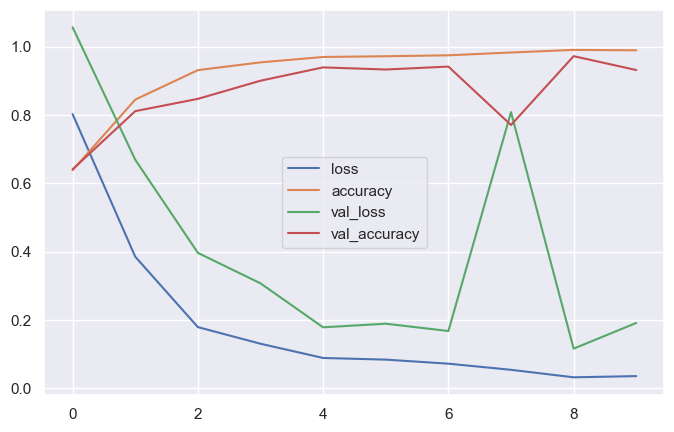

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


data = r'Dataset'
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    label_mode = 'categorical',
    validation_split=0.2,
    subset="training",
    seed = 0,
    color_mode = 'grayscale',
    image_size=(128, 128),
    batch_size=32,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    label_mode = 'categorical',
    validation_split=0.2,
    subset="validation",
    seed = 0,
    color_mode = 'grayscale',
    image_size=(128, 128),
    batch_size=32,
)

# model setup
EffNet = tf.keras.applications.EfficientNetB0(include_top=False)
EffNet.trainable = True

inputs = tf.keras.layers.Input(shape=((128,128) + (1,)), name = 'input_layer')
x = EffNet(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax', name = 'output_layer')(x)
model = tf.keras.Model(inputs, outputs)
Learning_rate = 0.001
model.compile(loss = 'categorical_crossentropy',optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = Learning_rate),metrics = ['accuracy'])
model.summary()

# Fit the model
graphs = model.fit(train_data, epochs = 10, validation_data = test_data,verbose = False)
pd.DataFrame(graphs.history).plot(figsize=(8, 5))

# Evaluate the model
model.evaluate(test_data)

## 3.4 RandomForest for Alzheimer Classification

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

x_train, x_test, y_train, y_test= train_test_split(resized_image_array, resized_image_array_label, test_size = 0.2)

# Initialize the Random Forest model with optimized parameters
rf = RandomForestClassifier(
    n_estimators=100,         # Number of trees in the forest
    max_depth=20,             # Maximum depth of each tree
    min_samples_split=10,     # Minimum samples required to split a node
    min_samples_leaf=5,       # Minimum samples required at each leaf node
    max_features='sqrt',      # Number of features to consider at each split
    n_jobs=-1,                # Use all available cores
    random_state=42
)

# Train the model
rf.fit(x_train, y_train)
y_pred = rf.predict(x_train)
y_true = y_train

# Assess the performance of the Random Forest model on Training data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))

# Now, use the Random Forest model to predict Test data
y_pred = rf.predict(x_test)
y_true = y_test

# Assess the performance of the Random Forest model on Testing data
print('Accuracy : ', metrics.accuracy_score(y_true, y_pred))



Accuracy :  0.999609375
Accuracy :  0.93125


# 4 Overall summary

The project successfully explored the application of various machine learning techniques to classify Alzheimer's disease stages from image data. Specifically, II utilized Random Forest, Support Vector Machine (SVM), and a deep learning model based on EfficientNetB0.

- Random Forest: The model achieved a training accuracy of approximately 99.96%, demonstrating strong performance on the training set. However, the validation accuracy was slightly lower at around 93.13%.

- SVM: The SVM model with a linear kernel achieved an exceptionally high training accuracy of 100%, while the validation accuracy was 97.8%. The SVM with an RBF kernel took over 120 minutes to train and achieved an accuracy of 86.21% on the training set and 81% on the validation set.

- Deep Learning (CNN): The convolutional neural network model was effective, achieving a validation accuracy of around 93.12%. This indicates the potential of deep learning models to generalize well on unseen data.

Overall, the project demonstrated the feasibility and effectiveness of using machine learning models for the classification of Alzheimer's disease stages. Future work could focus on further hyperparameter tuning, increasing the dataset size for better generalization, and exploring more advanced deep learning architectures to improve accuracy and efficiency.